In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers

Using TensorFlow backend.


In [2]:
vib_df = pd.read_csv("vib-data.csv")
vib_df.head()

,time-milli,time-seconds,timestamp,velocity_x,velocity_y,velocity_z,acceleration_x,acceleration_y,acceleration_z,temperature
0,1.554850e+12,1554854539,4/10/19 0:02,0.075195,0.118164,0.077148,0.032227,0.026367,0.024414,34.5
1,1.554850e+12,1554854680,4/10/19 0:04,0.073242,0.119141,0.081055,0.031250,0.027344,0.025391,34.5
2,1.554850e+12,1554854821,4/10/19 0:07,0.078125,0.121094,0.078125,0.032227,0.026367,0.025391,34.5
3,1.554860e+12,1554855242,4/10/19 0:14,0.073242,0.120117,0.078125,0.031250,0.027344,0.024414,34.5
4,1.554860e+12,1554855382,4/10/19 0:16,0.077148,0.118164,0.076172,0.032227,0.027344,0.025391,34.5


In [3]:
vib_df.shape

(193264, 10)

In [4]:
# extract required columns.
df = vib_df[['timestamp', 'velocity_x', 'velocity_y', 'velocity_z']]
df.head()

,timestamp,velocity_x,velocity_y,velocity_z
0,4/10/19 0:02,0.075195,0.118164,0.077148
1,4/10/19 0:04,0.073242,0.119141,0.081055
2,4/10/19 0:07,0.078125,0.121094,0.078125
3,4/10/19 0:14,0.073242,0.120117,0.078125
4,4/10/19 0:16,0.077148,0.118164,0.076172


In [5]:
# convert to date time.
df['time_stamp'] =  pd.to_datetime(df['timestamp'], format='%m/%d/%y %H:%M')

In [6]:
# drop keyAsString
df.drop('timestamp', axis=1, inplace=True)
df.head()

,velocity_x,velocity_y,velocity_z,time_stamp
0,0.075195,0.118164,0.077148,2019-04-10 00:02:00
1,0.073242,0.119141,0.081055,2019-04-10 00:04:00
2,0.078125,0.121094,0.078125,2019-04-10 00:07:00
3,0.073242,0.120117,0.078125,2019-04-10 00:14:00
4,0.077148,0.118164,0.076172,2019-04-10 00:16:00


In [7]:
# Sort values.
df.sort_values(by=['time_stamp'], inplace=True, ascending=True)
df.head()

,velocity_x,velocity_y,velocity_z,time_stamp
171734,0.081055,0.099609,0.125977,2018-08-31 18:22:00
171735,0.080078,0.089844,0.054688,2018-08-31 18:24:00
171736,0.083008,0.090820,0.053711,2018-08-31 18:26:00
171737,0.082031,0.093750,0.053711,2018-08-31 18:28:00
171738,0.081055,0.089844,0.051758,2018-08-31 18:30:00


In [8]:
# Aggregate values based on date.
df = df.resample('30min', on='time_stamp').mean()
df.head()

,velocity_x,velocity_y,velocity_z
time_stamp,,,
2018-08-31 18:00:00,0.081543,0.093506,0.072021
2018-08-31 18:30:00,0.083398,0.091536,0.056641
2018-08-31 19:00:00,0.080985,0.091936,0.056989
2018-08-31 19:30:00,0.075260,0.088411,0.076237
2018-08-31 20:00:00,0.065081,0.089495,0.059501


In [9]:

# Write this to CSV.
df.to_csv('sampled_data.csv')
df.head()

,velocity_x,velocity_y,velocity_z
time_stamp,,,
2018-08-31 18:00:00,0.081543,0.093506,0.072021
2018-08-31 18:30:00,0.083398,0.091536,0.056641
2018-08-31 19:00:00,0.080985,0.091936,0.056989
2018-08-31 19:30:00,0.075260,0.088411,0.076237
2018-08-31 20:00:00,0.065081,0.089495,0.059501


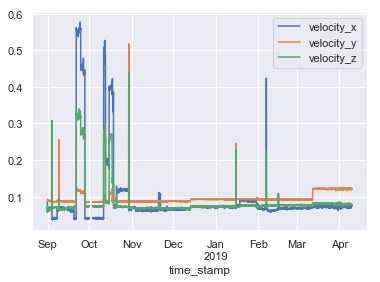

In [10]:
df_train = df.loc['2018-08-31 18:00:00':'4-10-19 1:30:00']

df_test = df.loc['4-10-19 1:30:00':]

df_train.plot()

In [11]:
#Normalize data.

scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(df_train), 
                              columns=df_train.columns, 
                              index=df_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(df_test), 
                             columns=df_test.columns, 
                             index=df_test.index)
print(X_train.isnull().sum())
print(X_test.isnull().sum())

X_train.dropna(axis = 0, inplace=True)
X_test.dropna(axis = 0, inplace=True)


print(X_train.isnull().sum())
print(X_train.isnull().sum())


velocity_x    334
velocity_y    334
velocity_z    334
dtype: int64
velocity_x    53
velocity_y    53
velocity_z    53
dtype: int64
velocity_x    0
velocity_y    0
velocity_z    0
dtype: int64
velocity_x    0
velocity_y    0
velocity_z    0
dtype: int64


In [12]:
# Build model.

seed(10)
set_random_seed(10)
act_func = 'relu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 20: 
NUM_EPOCHS=100
BATCH_SIZE=10

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# Fit model.

history=model.fit(np.array(X_train),
                  np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 9775 samples, validate on 515 samples
Epoch 1/100
9775/9775 [==============================] - 6s 649us/step - loss: 0.0062 - val_loss: 0.0017
Epoch 2/100
9775/9775 [==============================] - 3s 348us/step - loss: 5.6684e-04 - val_loss: 0.0017
Epoch 3/100
9775/9775 [==============================] - 3s 309us/step - loss: 5.0219e-04 - val_loss: 0.0015
Epoch 4/100
9775/9775 [==============================] - 3s 259us/step - loss: 4.3715e-04 - val_loss: 0.0018
Epoch 5/100
9775/9775 [==============================] - 3s 263us/step - loss: 4.3039e-04 - val_loss: 0.0016
Epoch 6/100
9775/9775 [==============================] - 4s 435us/step - loss: 4.2483e-04 - val_loss: 0.0016
Epoch 7/100
9775/9775 [==============================] - 4s 413us/step - loss: 4.2404e-04 - val_loss: 0.0015
Epoch 8/100
9775/9775 [==============================] - 4s 359us/step - loss: 4.2609e-04 - val_loss: 0.0016
Epoch 9/100
9775/9775 [==============

9775/9775 [==============================] - 2s 221us/step - loss: 3.6579e-04 - val_loss: 9.3621e-04
Epoch 73/100
9775/9775 [==============================] - 2s 208us/step - loss: 3.6919e-04 - val_loss: 9.7434e-04
Epoch 74/100
9775/9775 [==============================] - 2s 201us/step - loss: 3.7106e-04 - val_loss: 7.5197e-04
Epoch 75/100
9775/9775 [==============================] - 2s 206us/step - loss: 3.7860e-04 - val_loss: 9.2607e-04
Epoch 76/100
9775/9775 [==============================] - 2s 200us/step - loss: 3.6955e-04 - val_loss: 0.0011
Epoch 77/100
9775/9775 [==============================] - 2s 204us/step - loss: 3.5672e-04 - val_loss: 6.4244e-04
Epoch 78/100
9775/9775 [==============================] - 2s 209us/step - loss: 3.7270e-04 - val_loss: 8.8886e-04
Epoch 79/100
9775/9775 [==============================] - 2s 205us/step - loss: 3.6806e-04 - val_loss: 0.0012
Epoch 80/100
9775/9775 [==============================] - 2s 199us/step - loss: 3.7407e-04 - val_loss: 0.0010

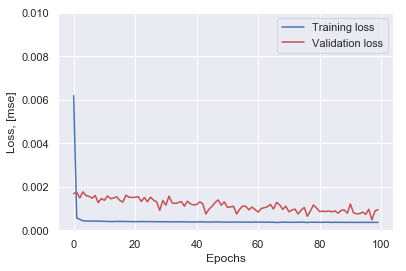

In [14]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.01])
plt.show()

(0.0, 0.8)

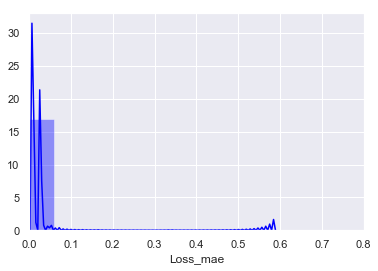

In [15]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.8])

In [16]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.58
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
time_stamp,,,
2019-04-10 01:30:00,0.025565,0.58,False
2019-04-10 02:00:00,0.025301,0.58,False
2019-04-10 02:30:00,0.026970,0.58,False
2019-04-10 03:00:00,0.026827,0.58,False
2019-04-10 03:30:00,0.025712,0.58,False


In [17]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.58
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

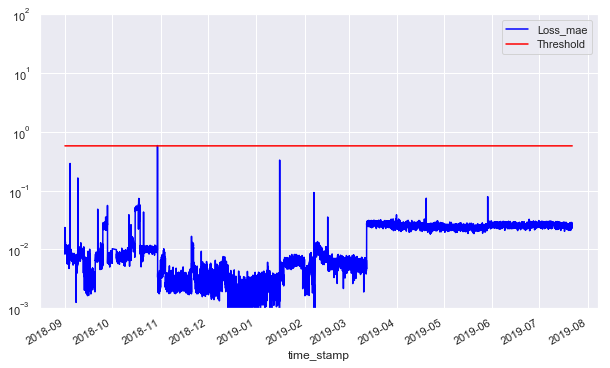

In [18]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e2], color = ['blue','red'])

In [19]:
scored[scored['Anomaly'] >= 0.58]

,Loss_mae,Threshold,Anomaly
time_stamp,,,
2018-10-29 21:00:00,0.586837,0.58,True
